# Set-up

In [1]:
# Import packages
import os
import sys
import numpy as np
import pandas as pd
import scanpy as sc
import decoupler as dc
import snapatac2 as snap
import scipy.stats as stats
sc.settings.verbosity = 0

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


/cellar/users/aklie/.local/lib/python3.9/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


In [2]:
# File paths
h5ads_path = "/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/annotation/timecourse/A2_3-cyt/snapatac2/merged.h5ads"
outdir_path = "/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/annotation/timecourse_analysis/A2_3-cyt/atac/windows"

# 
cell_annotations_path = "/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/annotation/timecourse/A2_3-cyt/2024_04_01/rna/regress_out/RNA_celltype.txt"
sample_metadata_path = "/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/metadata/2023_11_26/sample_metadata_26Nov23.tsv"
blacklist_path = "/cellar/users/aklie/data/ref/genomes/hg38/blacklist/blacklist.bed.gz"
cellid_colors_path = "/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/ref/2023_11_26/cellid_colors.tsv"

# Color paths
cellid_colors_path = "/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/ref/2023_11_26/cellid_colors.tsv"

# Make output directory
os.makedirs(outdir_path, exist_ok=True)

# Load and format data

In [3]:
# Load and inspect sample metadata
sample_metadata = pd.read_csv(sample_metadata_path, sep="\t")[['sample_id', 'sample_description', 'atac_library_id', 'rna_library_id','batch', 'timepoint', 'condition']]
sample_metadata.head()

# Load cell id colors
cellid_colors = pd.read_csv(cellid_colors_path, sep="\t", index_col=0, header=None)
cellid_colors = cellid_colors.to_dict()[1]
cellid_colors["SC.EC.1"] = cellid_colors["SC.EC"]
cellid_colors["SC.EC.2"] = "#FFA07A"

In [4]:
# Read in h5ad file
adataset = snap.read_dataset(h5ads_path)
adata = adataset.to_adata()
adataset.close()
adata

AnnData object with n_obs × n_vars = 30499 × 606219
    obs: 'sample', 'log_n_fragment', 'tsse', 'leiden_1'
    var: 'count', 'selected'
    uns: 'spectral_eigenvalue', 'reference_sequences', 'AnnDataSet'
    obsm: 'X_umap', 'X_spectral'
    obsp: 'distances'

In [5]:
# Merge metadata
bcs = adata.obs.index.tolist()
adata_obs = adata.obs.merge(sample_metadata, left_on="sample", right_on="sample_id")
adata_obs.index = bcs
adata.obs = adata_obs
adata.obs.head()

sample  log_n_fragment       tsse leiden_1 sample_id  \
dm11a#AAACAGCCACACAATT-1  dm11a        4.372967  15.601693        3     dm11a   
dm11a#AAACAGCCAGCAGGTA-1  dm11a        3.998869  16.723627        3     dm11a   
dm11a#AAACATGCACTTACAG-1  dm11a        4.117205  18.423782        8     dm11a   
dm11a#AAACATGCATAGTCAT-1  dm11a        3.494155  28.429752        3     dm11a   
dm11a#AAACCAACAACTAACT-1  dm11a        3.618676  17.396184        3     dm11a   

                         sample_description atac_library_id rna_library_id  \
dm11a#AAACAGCCACACAATT-1          6hr_3-cyt            WB_7           WB_8   
dm11a#AAACAGCCAGCAGGTA-1          6hr_3-cyt            WB_7           WB_8   
dm11a#AAACATGCACTTACAG-1          6hr_3-cyt            WB_7           WB_8   
dm11a#AAACATGCATAGTCAT-1          6hr_3-cyt            WB_7           WB_8   
dm11a#AAACCAACAACTAACT-1          6hr_3-cyt            WB_7           WB_8   

                         batch  timepoint condition  
dm11a#AAACAGCCACACAATT-1    A2          6     3-cyt  
dm11a#AAACAGCCAGCAGGTA-1    A2          6     3-cyt  
dm11a#AAACATGCACTTACAG-1    A2          6     3-cyt  
dm11a#AAACATGCATAGTCAT-1    A2          6     3-cyt  
dm11a#AAACCAACAACTAACT-1    A2          6     3-cyt

In [6]:
# Add in cell annotation
cell_annotations = pd.read_csv(cell_annotations_path, sep="\t", index_col=0, header=None)
cell_annotations = cell_annotations.to_dict()[1]
adata.obs['annotation'] = adata.obs.index.map(cell_annotations)
adata.obs["annotation"].value_counts(dropna=False)

NaN         21187
SC.beta      3277
SC.alpha     2975
SC.EC.2      1744
SC.EC.1      1316
Name: annotation, dtype: int64

In [47]:
# Remove any colors that are not in the data
cellid_colors = {k: v for k, v in cellid_colors.items() if k in adata.obs["annotation"].unique()}

# Cell id should be a categorical variable 
adata.obs["annotation"] = adata.obs["annotation"].astype("category")
adata.obs["annotation"] = adata.obs["annotation"].cat.reorder_categories(cellid_colors.keys())
adata.uns["annotation_colors"] = list(cellid_colors.values())

# Filter to cells with annotation

/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


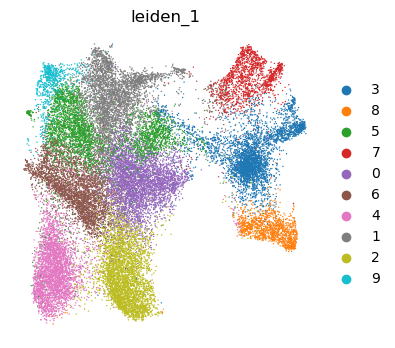

In [11]:
with plt.rc_context({'figure.figsize': (4, 4)}):
    sc.pl.umap(adata, color="leiden_1", show=False, frameon=False)

/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


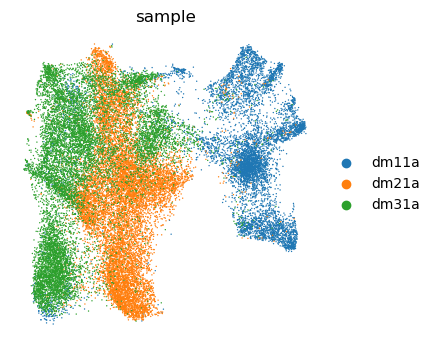

In [12]:
with plt.rc_context({'figure.figsize': (4, 4)}):
    sc.pl.umap(adata, color="sample", show=False, frameon=False)

/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


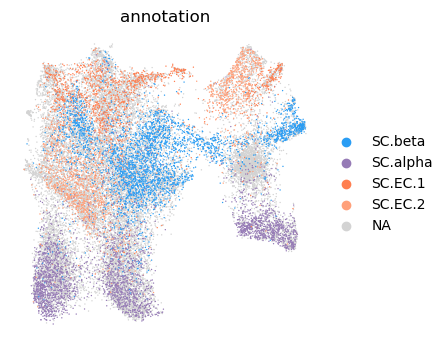

In [13]:
with plt.rc_context({'figure.figsize': (4, 4)}):
    sc.pl.umap(adata, color="annotation", show=False, frameon=False)

In [14]:
# Filter to cells with annotation not NaN
adata_filt = adata[adata.obs["annotation"].notna()].copy()
adata_filt

AnnData object with n_obs × n_vars = 9312 × 606219
    obs: 'sample', 'log_n_fragment', 'tsse', 'leiden_1', 'sample_id', 'sample_description', 'atac_library_id', 'rna_library_id', 'batch', 'timepoint', 'condition', 'annotation'
    var: 'count', 'selected'
    uns: 'spectral_eigenvalue', 'reference_sequences', 'AnnDataSet', 'annotation_colors', 'leiden_1_colors', 'sample_colors'
    obsm: 'X_umap', 'X_spectral'
    obsp: 'distances'

/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


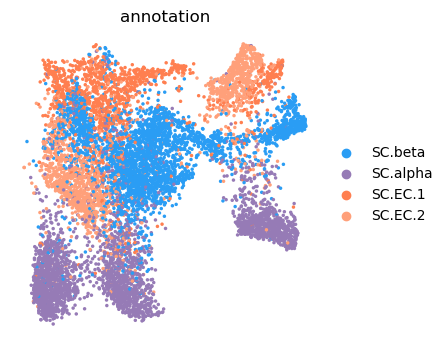

In [17]:
with plt.rc_context({'figure.figsize': (4, 4)}):
    sc.pl.umap(adata_filt, color="annotation", show=False, frameon=False, s=25)

In [16]:
adata_filt.obs["annotation"].value_counts(dropna=False)

SC.beta     3277
SC.alpha    2975
SC.EC.2     1744
SC.EC.1     1316
Name: annotation, dtype: int64

# (Optional) Tighter QC filters

## TSSE

/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py39/lib/python3.9/site-packages/scanpy/plotting/_anndata.py:840: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


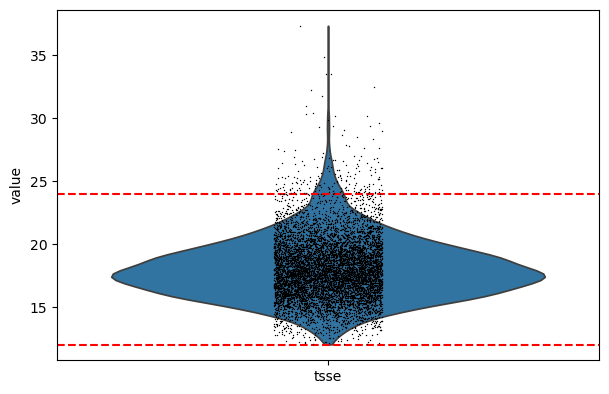

In [ ]:
ax = sc.pl.violin(adata_filt, keys=["tsse"], show=False)
ax.axhline(12, color="red", linestyle="--")
ax.axhline(24, color="red", linestyle="--")

In [ ]:
# Filter out 
adata_filt = adata_filt[(adata_filt.obs["tsse"] > 12) & (adata_filt.obs["tsse"] < 24)].copy()
adata_filt

AnnData object with n_obs × n_vars = 8175 × 606219
    obs: 'sample', 'log_n_fragment', 'tsse', 'leiden_1', 'sample_id', 'sample_description', 'atac_library_id', 'rna_library_id', 'batch', 'timepoint', 'condition', 'annotation', 'spectral1', 'spectral2', 'spectral3', 'spectral4', 'spectral5', 'spectral6', 'spectral7', 'spectral8', 'spectral9', 'spectral10'
    var: 'count', 'selected'
    uns: 'AnnDataSet', 'spectral_eigenvalue', 'reference_sequences', 'timepoint_colors', 'annotation_colors'
    obsm: 'X_umap', 'X_spectral'
    obsp: 'distances'

/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py39/lib/python3.9/site-packages/scanpy/plotting/_anndata.py:840: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


<Axes: ylabel='value'>

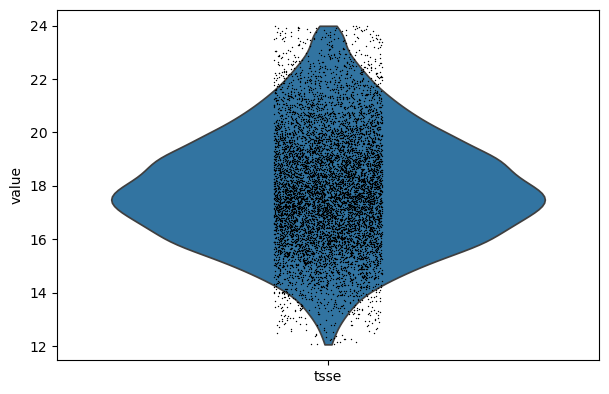

In [ ]:
sc.pl.violin(adata_filt, keys=["tsse"], show=False)

<Axes: title={'center': 'tsse'}, xlabel='UMAP1', ylabel='UMAP2'>

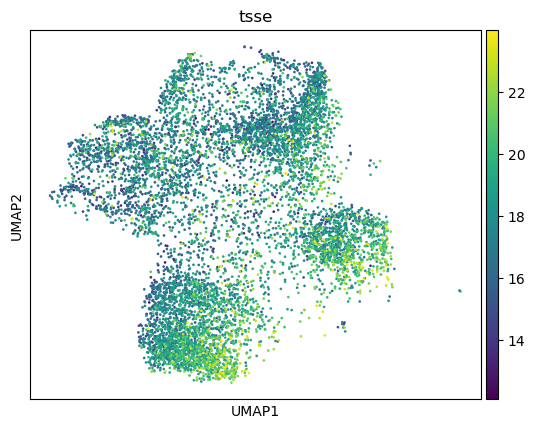

In [ ]:
sc.pl.umap(adata_filt, color=["tsse"], show=False)

In [ ]:
adata_filt.obs["annotation"].value_counts(dropna=False)

SC.alpha    2688
SC.beta     2593
SC.EC.1     1671
SC.EC.2     1169
SC.delta      54
Name: annotation, dtype: int64

## Total counts

/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py39/lib/python3.9/site-packages/scanpy/plotting/_anndata.py:840: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


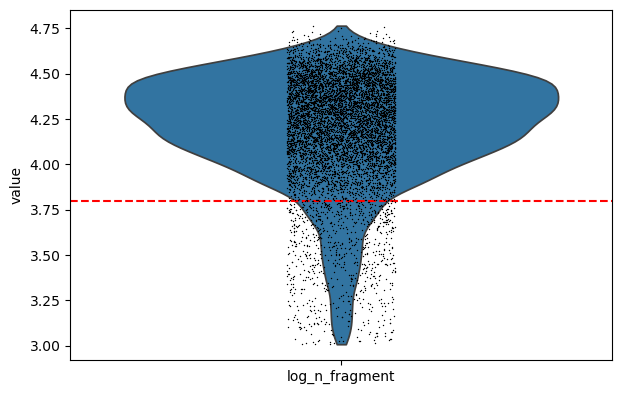

In [ ]:
ax = sc.pl.violin(adata_filt, keys=["log_n_fragment"], show=False)
ax.axhline(3.8, color="red", linestyle="--")

In [ ]:
# Keep only cells with > 3.8
adata_filt = adata_filt[adata_filt.obs["log_n_fragment"] > 3.8].copy()
adata_filt

AnnData object with n_obs × n_vars = 7355 × 606219
    obs: 'sample', 'log_n_fragment', 'tsse', 'leiden_1', 'sample_id', 'sample_description', 'atac_library_id', 'rna_library_id', 'batch', 'timepoint', 'condition', 'annotation', 'spectral1', 'spectral2', 'spectral3', 'spectral4', 'spectral5', 'spectral6', 'spectral7', 'spectral8', 'spectral9', 'spectral10'
    var: 'count', 'selected'
    uns: 'AnnDataSet', 'spectral_eigenvalue', 'reference_sequences', 'timepoint_colors', 'annotation_colors'
    obsm: 'X_umap', 'X_spectral'
    obsp: 'distances'

/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py39/lib/python3.9/site-packages/scanpy/plotting/_anndata.py:840: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


<Axes: ylabel='value'>

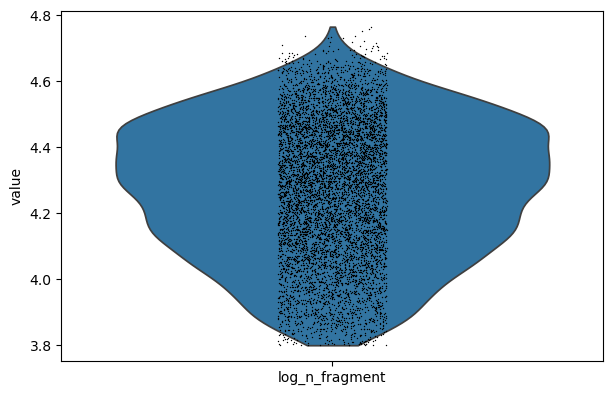

In [ ]:
sc.pl.violin(adata_filt, keys=["log_n_fragment"], show=False)

In [ ]:
adata_filt.obs["annotation"].value_counts(dropna=False)

SC.alpha    2410
SC.beta     2355
SC.EC.1     1485
SC.EC.2     1058
SC.delta      47
Name: annotation, dtype: int64

<Axes: title={'center': 'log_n_fragment'}, xlabel='UMAP1', ylabel='UMAP2'>

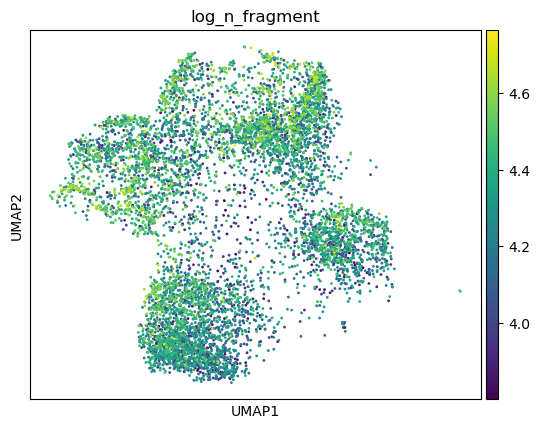

In [ ]:
sc.pl.umap(adata_filt, color=["log_n_fragment"], show=False)

# Reprocess filtered data with SnapATAC2

In [18]:
# Select features
snap.pp.select_features(adata_filt, n_features=500000, blacklist=blacklist_path)

2024-04-15 09:12:55 - INFO - Selected 499350 features.


In [19]:
# Spectral embedding
snap.tl.spectral(adata_filt, random_state=1234)

In [20]:
# Remove the first dimension of adata_filt.obsm["spectral"]
old_spectral = adata_filt.obsm['X_spectral'].copy()
adata_filt.obsm['X_spectral'] = adata_filt.obsm['X_spectral'][:, 1:]

In [21]:
# Run neighbors
sc.pp.neighbors(adata_filt, n_pcs=adata_filt.obsm["X_spectral"].shape[1], n_neighbors=30, random_state=1234, use_rep="X_spectral")

/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py39/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [22]:
# many leidens
sc.tl.leiden(adata_filt, resolution=0.2, key_added="leiden_0.2", random_state=1234)
sc.tl.leiden(adata_filt, resolution=0.5, key_added="leiden_0.5", random_state=1234)
sc.tl.leiden(adata_filt, resolution=0.8, key_added="leiden_0.8", random_state=1234)
sc.tl.leiden(adata_filt, resolution=1, key_added="leiden_1", random_state=1234)
sc.tl.leiden(adata_filt, resolution=1.5, key_added="leiden_1.5", random_state=1234)

/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


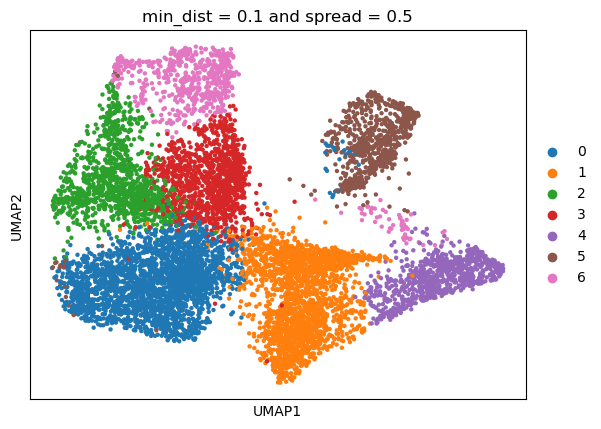

/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


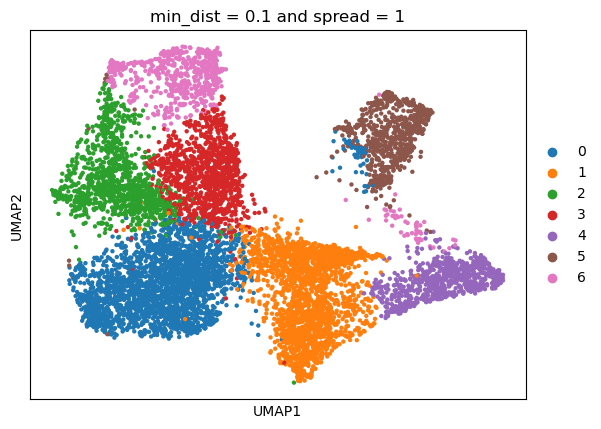

/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py39/lib/python3.9/site-packages/umap/umap_.py:1393: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


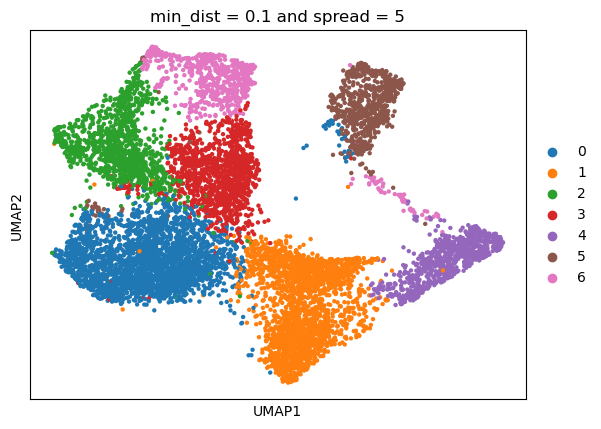

/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


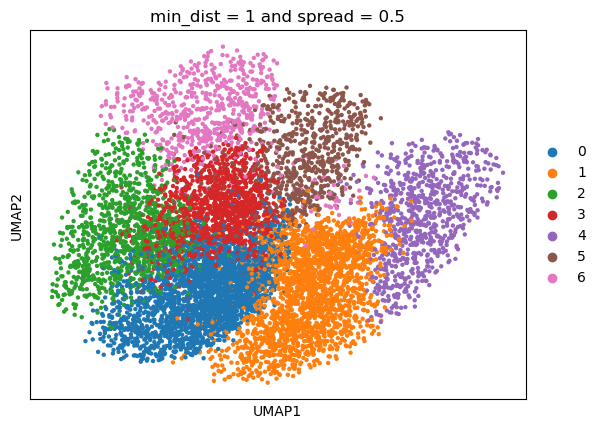

/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


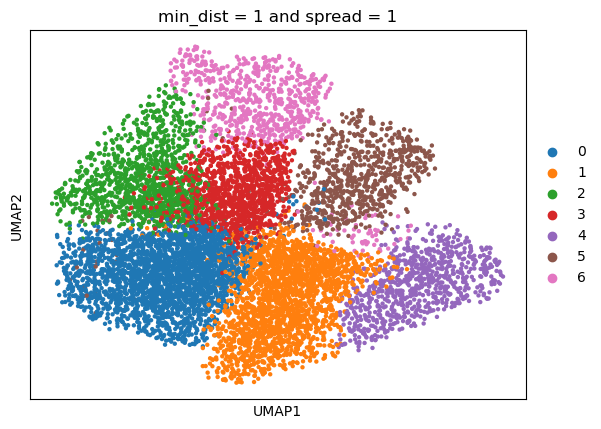

/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py39/lib/python3.9/site-packages/umap/umap_.py:1393: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


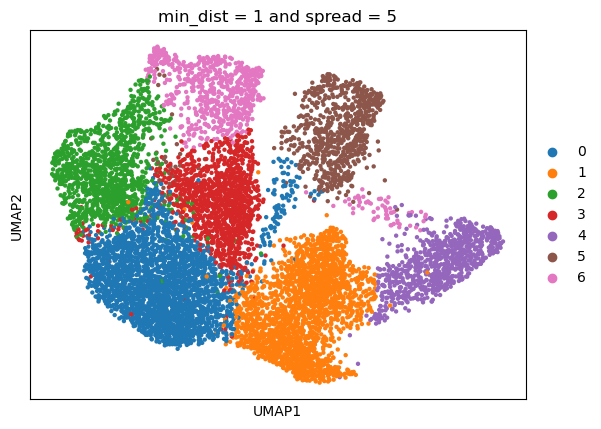

/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py39/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


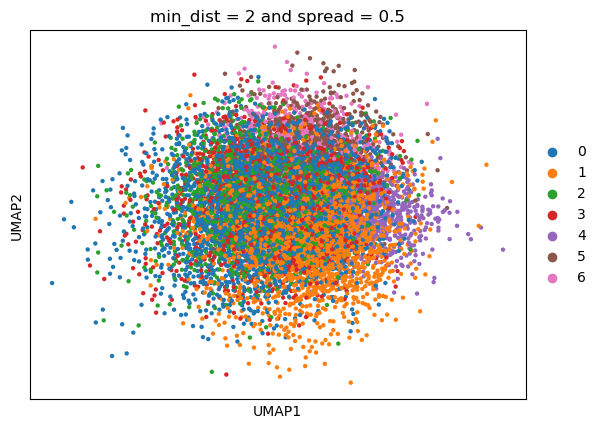

/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py39/lib/python3.9/site-packages/umap/umap_.py:1393: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


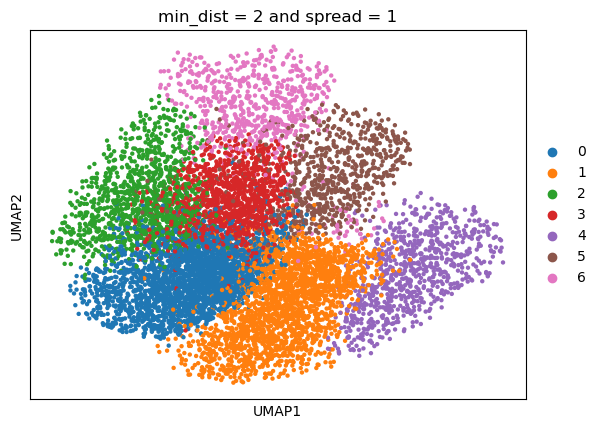

/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py39/lib/python3.9/site-packages/umap/umap_.py:1393: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


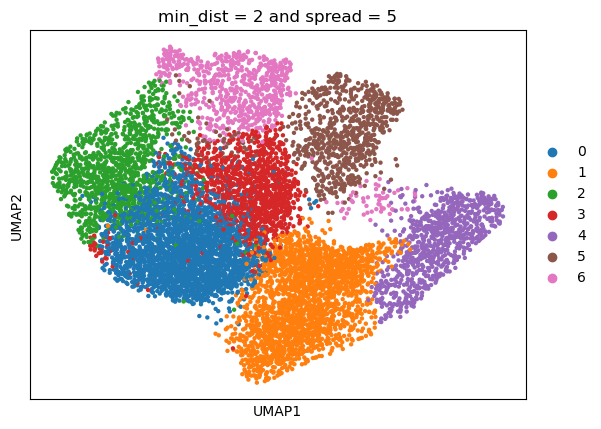

In [23]:
# Copy adata not to modify UMAP in the original adata object
adata_temp = adata_filt.copy()

# Loop through different umap parameters, recomputting and replotting UMAP for each of them
for min_dist in [0.1, 1, 2]:
    for spread in [0.5, 1, 5]:
        param_str = " ".join(["min_dist =", str(min_dist), "and spread =", str(spread)])
        sc.tl.umap(adata_temp, min_dist=min_dist, spread=spread)
        # Display plot and then immediately close it to ensure that
        # we do not open too many plot windows at once
        g = sc.pl.umap(
            adata_temp,
            color=["leiden_0.5"],
            title=param_str,
            s=40,
            show=False,
            return_fig=True,
        )
        display(g)
        plt.close()
del adata_temp

In [24]:
# Run UMAP
sc.tl.umap(adata_filt, spread=1, min_dist=0.4, random_state=1234)

/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cellar/users/aklie/opt/miniconda3/envs/scverse-lite

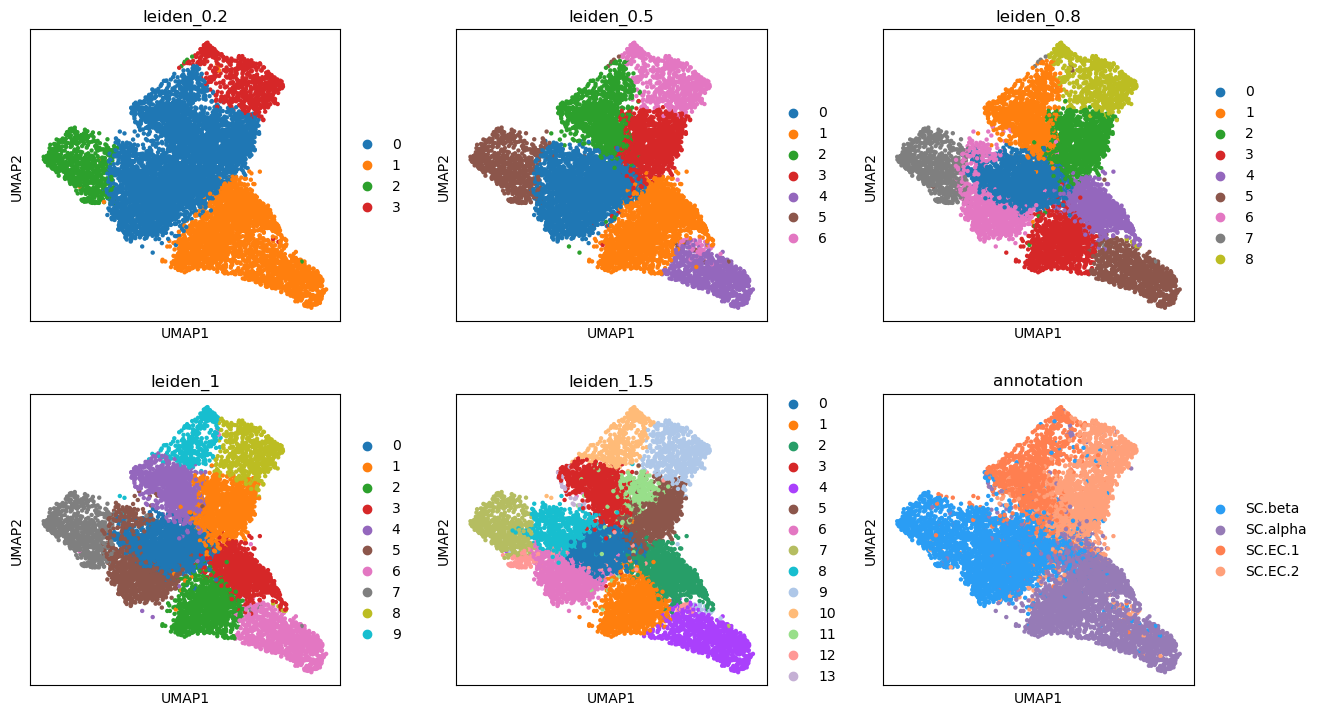

In [25]:
# Check different clustering res
with plt.rc_context({'figure.figsize': (4, 4)}):
    sc.pl.umap(adata_filt, color=["leiden_0.2", "leiden_0.5", "leiden_0.8", "leiden_1", "leiden_1.5", "annotation"], ncols=3, s=40, wspace=0.25, show=False)

/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


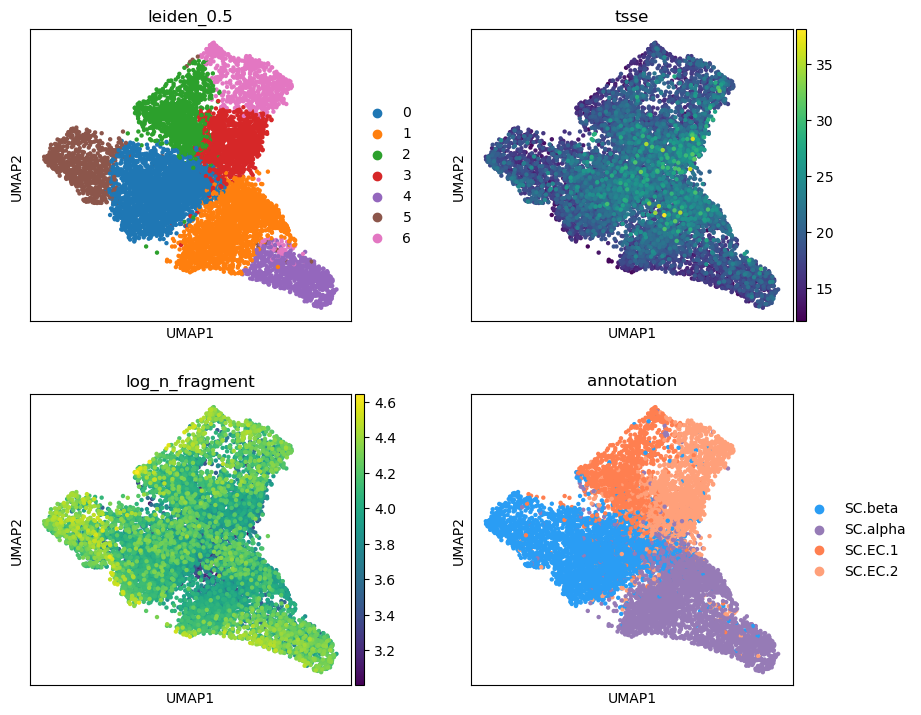

In [26]:
with plt.rc_context({'figure.figsize': (4, 4)}):
    sc.pl.umap(adata_filt, color=["leiden_0.5", "tsse", "log_n_fragment", "annotation"], ncols=2, wspace=0.25, s=40, show=False)

/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


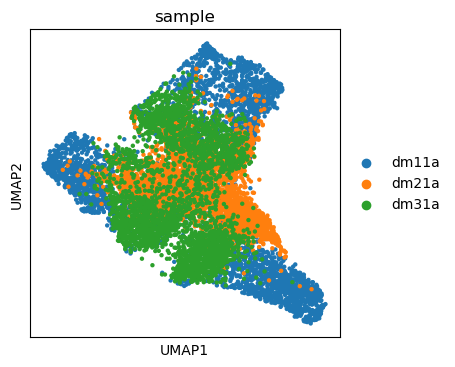

In [31]:
with plt.rc_context({'figure.figsize': (4, 4)}):
    sc.pl.umap(adata_filt, color=["sample"], s=40, show=False)

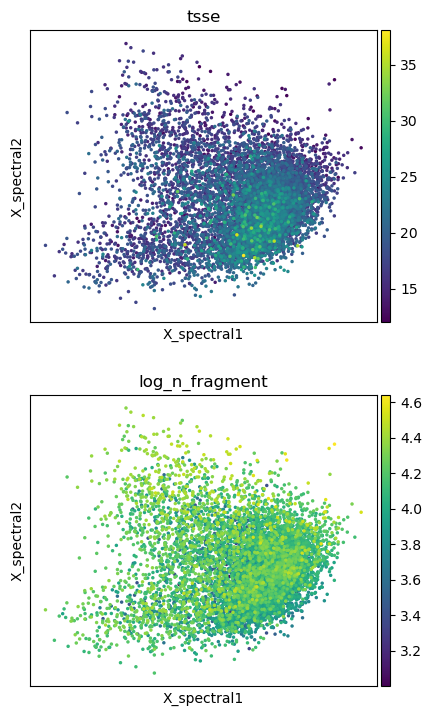

In [27]:
with plt.rc_context({'figure.figsize': (4, 4)}):
    sc.pl.embedding(adata_filt, basis="X_spectral", color=["tsse", "log_n_fragment"], s=25, ncols=1, show=False)

/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


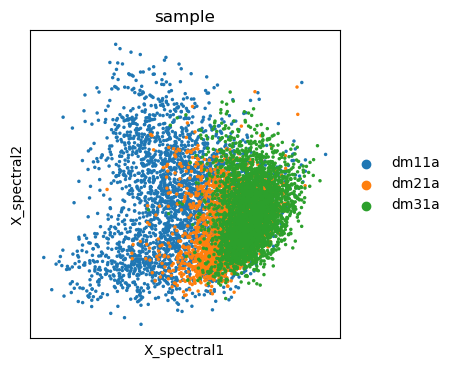

In [29]:
with plt.rc_context({'figure.figsize': (4, 4)}):
    sc.pl.embedding(adata_filt, basis="X_spectral", color=["sample"], s=25, ncols=1, show=False)

# Removing cells that cluster differently in RNA and ATAC

Text(0.5, 1.0, 'annotation proportions in leiden clusters')

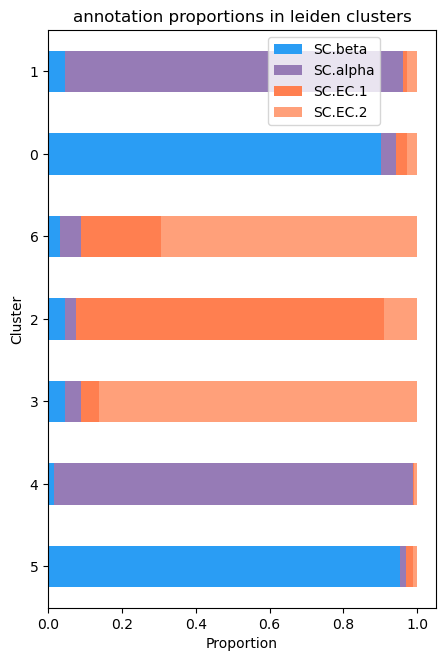

In [32]:
# Stacked barplot of annotation proportions in leiden clusters
leiden = adata_filt.obs["leiden_0.5"].unique().tolist()
annotation_proportions = []
for cluster in leiden:
    proportions = adata_filt.obs[adata_filt.obs["leiden_0.5"] == cluster]["annotation"].value_counts(normalize=True, dropna=False)
    proportions.name = cluster
    annotation_proportions.append(proportions)
annotation_proportions = pd.concat(annotation_proportions, axis=1).T
annotation_proportions = annotation_proportions[cellid_colors.keys()]

# Plot horizontal barplot, legend outside to right
fig, ax = plt.subplots(figsize=(5, 7.5))
annotation_proportions.plot.barh(stacked=True, ax=ax, color=cellid_colors.values())
plt.legend(bbox_to_anchor=(0.55, 1), loc='upper left')
plt.xlabel("Proportion")
plt.ylabel("Cluster")
plt.title("annotation proportions in leiden clusters")

In [33]:
pd.crosstab(adata_filt.obs["leiden_0.5"], adata_filt.obs["annotation"])

annotation  SC.beta  SC.alpha  SC.EC.1  SC.EC.2
leiden_0.5                                     
0              2319       108       71       74
1                97      1948       26       56
2                55        34      997      107
3                54        51       55     1011
4                12       782        2        7
5               718        13       15        8
6                22        39      150      481

In [34]:
# Find the majority of each cluster and remove all cells in that cluster not in the majority
barcodes_to_keep = []
for cluster in adata_filt.obs["leiden_0.5"].unique():
    majority_annotation = adata_filt.obs[adata_filt.obs["leiden_0.5"] == cluster]["annotation"].value_counts().idxmax()
    barcodes_to_keep += adata_filt.obs[(adata_filt.obs["leiden_0.5"] == cluster) & (adata_filt.obs["annotation"] == majority_annotation)].index.tolist()
len(barcodes_to_keep)

8256

In [43]:
# Filter to barcodes to keep
adata_filt = adata_filt[barcodes_to_keep].copy()
adata_filt

AnnData object with n_obs × n_vars = 8256 × 606219
    obs: 'sample', 'log_n_fragment', 'tsse', 'leiden_1', 'sample_id', 'sample_description', 'atac_library_id', 'rna_library_id', 'batch', 'timepoint', 'condition', 'annotation', 'leiden_0.2', 'leiden_0.5', 'leiden_0.8', 'leiden_1.5'
    var: 'count', 'selected'
    uns: 'spectral_eigenvalue', 'reference_sequences', 'AnnDataSet', 'leiden_1_colors', 'sample_colors', 'neighbors', 'leiden', 'umap', 'leiden_0.2_colors', 'leiden_0.5_colors', 'leiden_0.8_colors', 'leiden_1.5_colors'
    obsm: 'X_umap', 'X_spectral'
    obsp: 'distances', 'connectivities'

In [44]:
pd.crosstab(adata_filt.obs["leiden_0.5"], adata_filt.obs["annotation"])

annotation  SC.beta  SC.alpha  SC.EC.1  SC.EC.2
leiden_0.5                                     
0              2319         0        0        0
1                 0      1948        0        0
2                 0         0      997        0
3                 0         0        0     1011
4                 0       782        0        0
5               718         0        0        0
6                 0         0        0      481

/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


[<Axes: title={'center': 'leiden_0.5'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <Axes: title={'center': 'tsse'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <Axes: title={'center': 'log_n_fragment'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <Axes: title={'center': 'annotation'}, xlabel='UMAP1', ylabel='UMAP2'>]

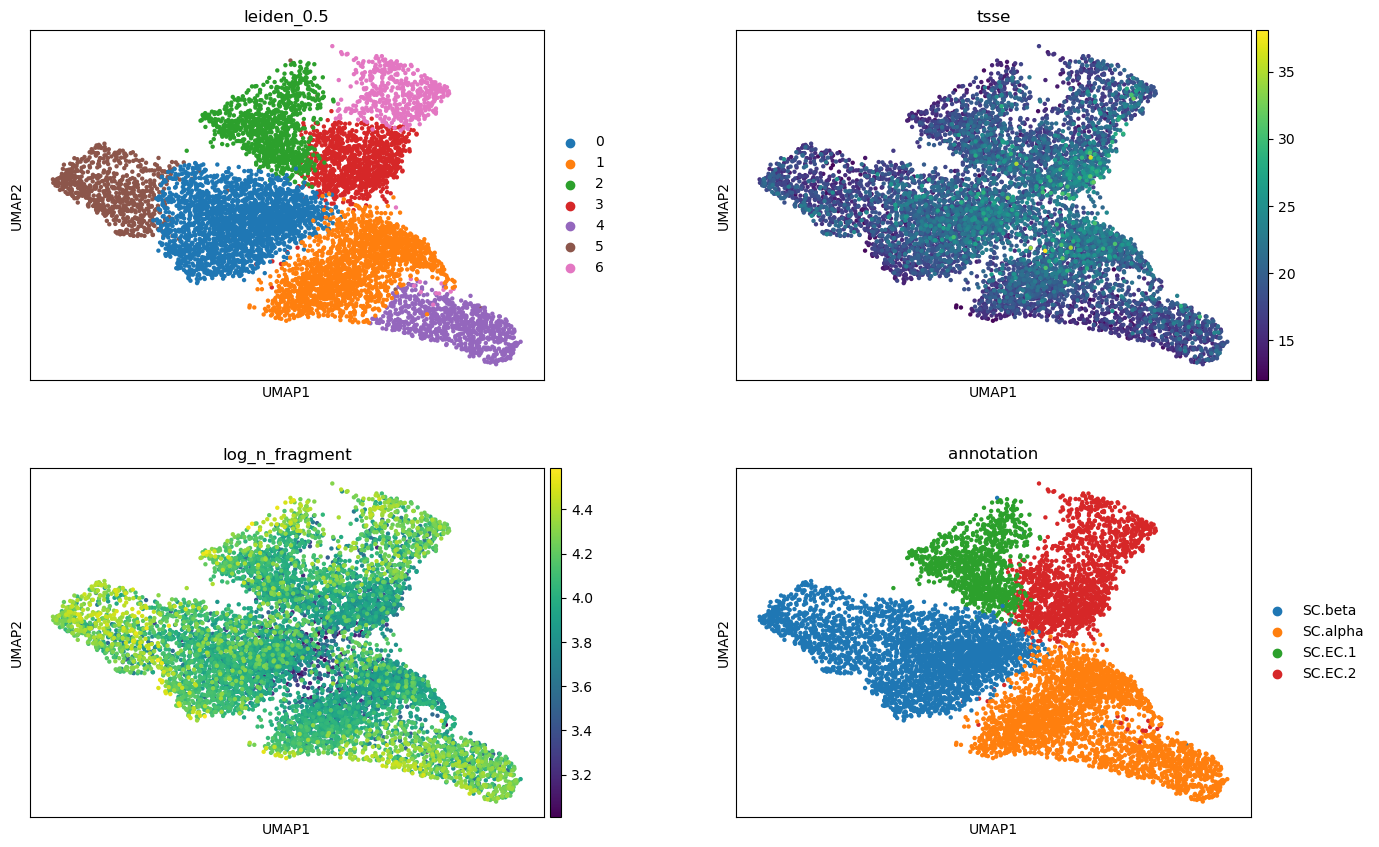

In [45]:
sc.pl.umap(adata_filt, color=["leiden_0.5", "tsse", "log_n_fragment", "annotation"], ncols=2, wspace=0.25, s=40, show=False)

# Presentation plots

In [52]:
# Remove any colors that are not in the data
cellid_colors = {k: v for k, v in cellid_colors.items() if k in adata_filt.obs["annotation"].unique()}

# Cell id should be a categorical variable 
adata_filt.obs["annotation"] = adata_filt.obs["annotation"].astype("category")
adata_filt.obs["annotation"] = adata_filt.obs["annotation"].cat.reorder_categories(cellid_colors.keys())
adata_filt.uns["annotation_colors"] = list(cellid_colors.values())

/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


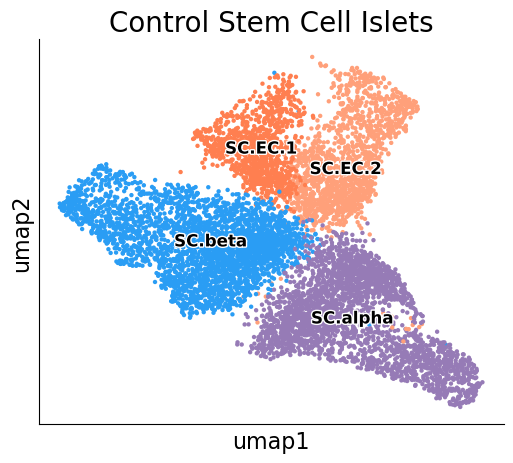

Error in atexit._run_exitfuncs:
Traceback (most recent call last):
  File "/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py39/lib/python3.9/site-packages/IPython/core/history.py", line 844, in writeout_cache
    self._writeout_input_cache(conn)
  File "/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py39/lib/python3.9/site-packages/IPython/core/history.py", line 827, in _writeout_input_cache
    conn.execute("INSERT INTO history VALUES (?, ?, ?, ?)",
sqlite3.DatabaseError: database disk image is malformed


In [53]:
fig, ax = plt.subplots(1, 1, figsize=(6,5))
sc.pl.umap(
    adata_filt, 
    color=["annotation"], 
    s=40, 
    show=False, 
    frameon=False, 
    legend_loc="on data",
    legend_fontsize=12,
    legend_fontoutline=2,
    title="Control Stem Cell Islets",
    ax=ax
)
ax.axis("on")
ax.tick_params(
    top="off",
    bottom="on",
    left="on",
    right="off",
    labelleft="on",
    labelbottom="off",
)
_ = ax.set_xlabel("umap1", fontsize=16)
_ = ax.set_ylabel("umap2", fontsize=16)
_ = ax.set_title("Control Stem Cell Islets", fontsize=20)


#ax.set(frame_on=False)
# Set bottom and left spines to on
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.savefig(os.path.join(outdir_path, "umap_updated_annotation.png"), bbox_inches="tight")

In [50]:
annotation_ordering = [
    "SC.alpha",
    "SC.beta",
    "SC.EC.1",
    "SC.EC.2",
    #"SC.delta"
]

2024-04-15 09:39:17 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-04-15 09:39:17 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


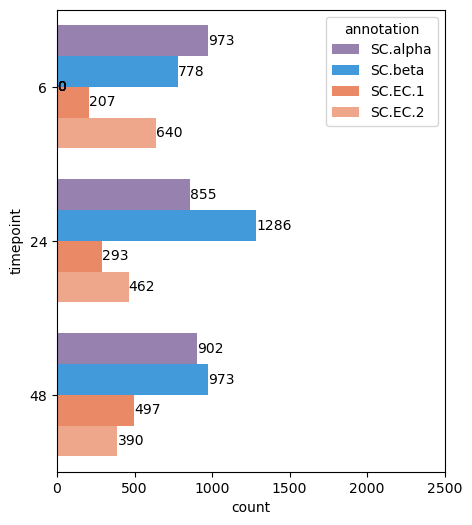

In [51]:
# Horizontal barplot showing number of cells (x) in each sample (y) colored by updated annotation
fig, ax = plt.subplots(1, 1, figsize=(5, 6))

# Plot
sns.countplot(
    y="timepoint",
    data=adata_filt.obs,
    hue="annotation",
    ax=ax,
    palette=cellid_colors,
    hue_order=annotation_ordering
)

ax.set_xlim(0, 2500)

# Add count numbers to right of each bar
for p in ax.patches:
    width = p.get_width()
    ax.text(width, p.get_y() + p.get_height() / 2, f"{int(width)}", ha="left", va="center")

plt.savefig(os.path.join(outdir_path, "celltype_proportions.png"), bbox_inches="tight")

# Clean up and save

## Full anndata

In [35]:
del adata_filt.uns["annotation_colors"]
#del adata_filt.uns["macs3"]

In [36]:
adata_filt.obs.to_csv(os.path.join(outdir_path, "ATAC_cell_metadata.tsv"), sep="\t", index=True)

In [37]:
adata_filt.write(os.path.join(outdir_path, "ATAC_full.h5ad"))

In [38]:
adata_filt.obs["annotation"].to_csv(os.path.join(outdir_path, "ATAC_celltype.txt"), sep="\t", index=True, header=False)

## Slim version (keep raw counts, obs, var and X_umap and X_pca)

In [39]:
adata_slim = adata_filt.copy()

In [40]:
del adata_slim.uns
del adata_slim.obsp

In [41]:
# Drop all columns with PC in obs
adata_slim.obs.drop(columns=adata_slim.obs.columns[adata_slim.obs.columns.str.contains("spectral")], inplace=True)
adata_slim

AnnData object with n_obs × n_vars = 9312 × 606219
    obs: 'sample', 'log_n_fragment', 'tsse', 'leiden_1', 'sample_id', 'sample_description', 'atac_library_id', 'rna_library_id', 'batch', 'timepoint', 'condition', 'annotation', 'leiden_0.2', 'leiden_0.5', 'leiden_0.8', 'leiden_1.5'
    var: 'count', 'selected'
    obsm: 'X_umap', 'X_spectral'

In [42]:
adata_slim.write(os.path.join(outdir_path, "ATAC_slim.h5ad"))

# DONE!

---

# Scratch